In [34]:
import pandas as pd
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [35]:
# 读取数据
data = pd.read_csv('electricityConsumptionAndProductioction.csv')


In [36]:
# 将DateTime列转换为时间格式，并设置为索引
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [37]:
# 描述性统计
print(data.describe())

        Consumption    Production       Nuclear          Wind  Hydroelectric  \
count  46011.000000  46011.000000  46011.000000  46011.000000   46011.000000   
mean    6587.616440   6518.645628   1291.177501    792.310882    1857.052444   
std     1043.654923    986.805018    236.549637    675.812712     692.592157   
min     3889.000000   3315.000000    562.000000    -26.000000     175.000000   
25%     5773.000000   5814.000000   1347.000000    236.000000    1347.000000   
50%     6552.000000   6462.000000   1383.000000    592.000000    1747.000000   
75%     7321.000000   7176.000000   1405.000000   1205.000000    2265.000000   
max     9615.000000   9886.000000   1457.000000   2811.000000    4434.000000   

        Oil and Gas          Coal         Solar       Biomass  
count  46011.000000  46011.000000  46011.000000  46011.000000  
mean    1171.890418   1193.157332    156.688031     55.851862  
std      434.748917    320.449368    229.502650     14.235554  
min      198.000000    

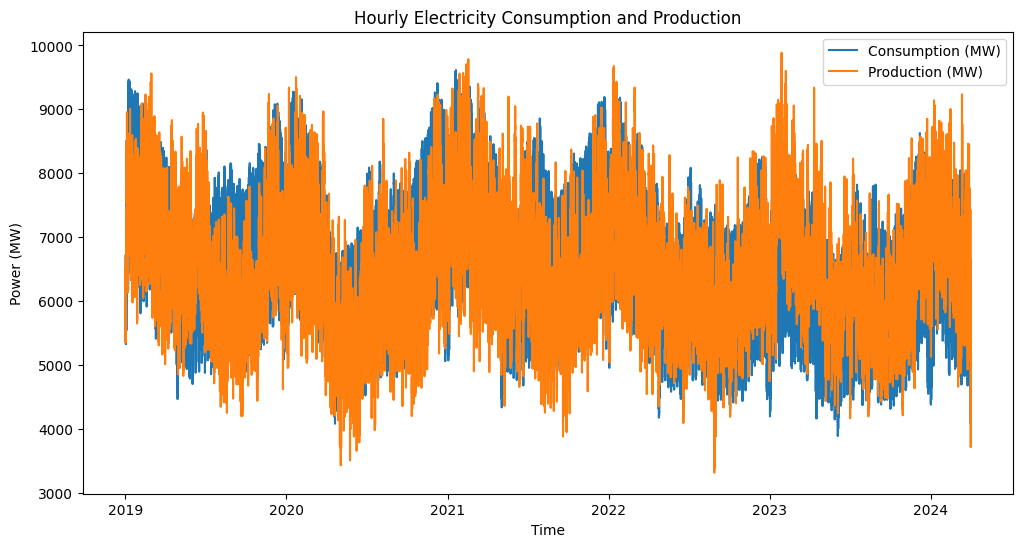

In [38]:
# 绘制电力消耗和生产的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Consumption'], label='Consumption (MW)')
plt.plot(data.index, data['Production'], label='Production (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

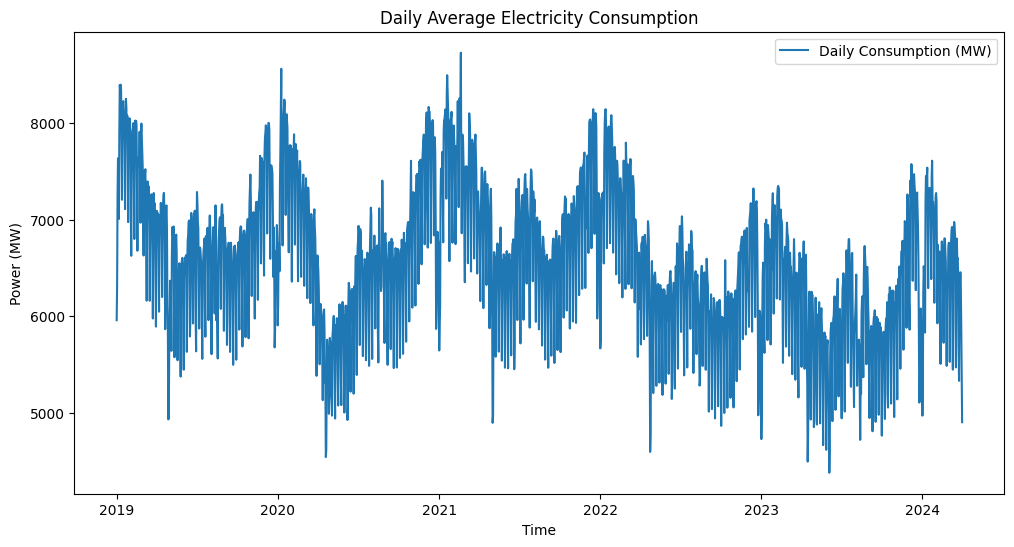

In [39]:
# 按天聚合
daily_data = data.resample('D').mean()

# 绘制每日平均电力消耗
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Consumption'], label='Daily Consumption (MW)')
plt.title('Daily Average Electricity Consumption')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

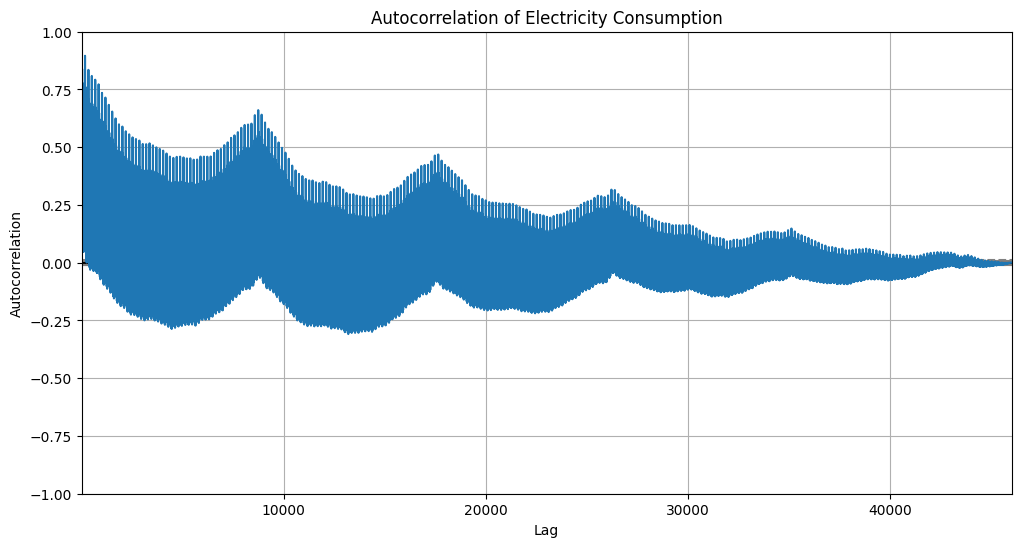

In [40]:
# 绘制自相关图
plt.figure(figsize=(12, 6))
autocorrelation_plot(data['Consumption'])
plt.title('Autocorrelation of Electricity Consumption')
plt.show()

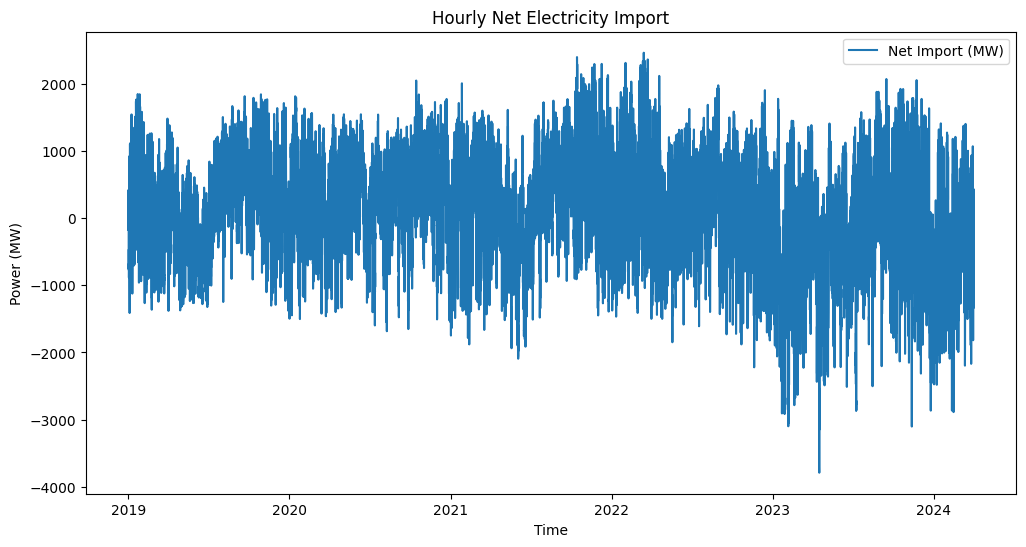

In [41]:
# 计算电力进出口
data['Net Import'] = data['Consumption'] - data['Production']

# 绘制电力进出口的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Net Import'], label='Net Import (MW)')
plt.title('Hourly Net Electricity Import')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

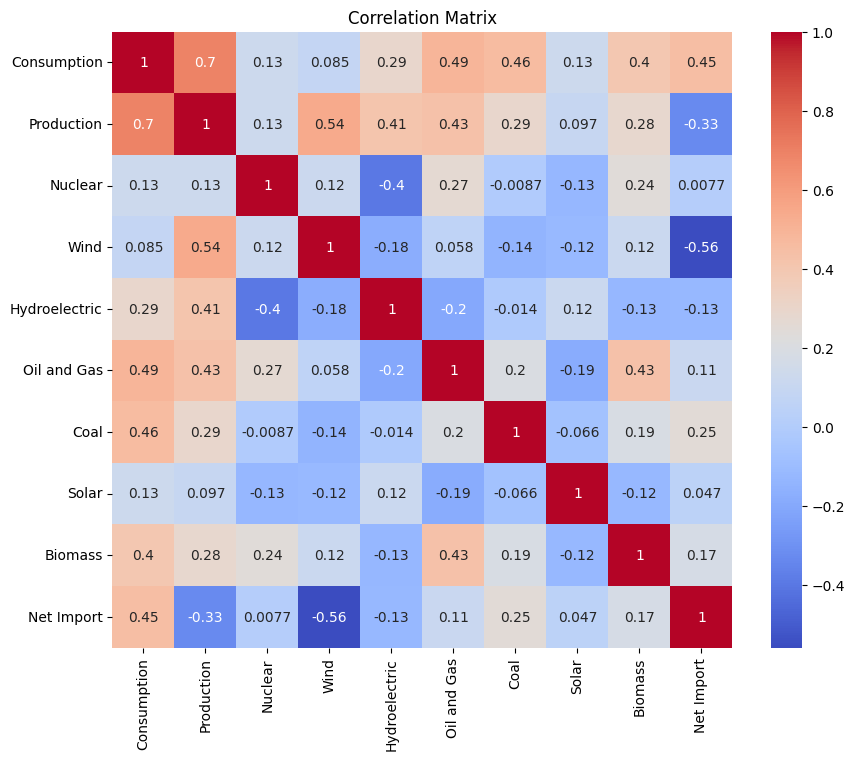

In [42]:
# 计算相关性矩阵
correlation_matrix = data.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [3]:
# 特征和目标变量
X = data.drop(columns=['Consumption'])
y = data['Consumption']

In [4]:
# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# 滚动窗口交叉验证
def rolling_window_cross_validation(X, y, model, param_grid, model_type='rf'):
    tscv = TimeSeriesSplit(n_splits=3)
    results = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # 使用iloc避免警告
        
        if model_type == 'lstm':
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        # 超参数调优
        best_params = {}
        best_score = float('inf')
        
        if model_type == 'rf':
            for n_estimators in param_grid['n_estimators']:
                for max_features in param_grid['max_features']:
                    for max_depth in param_grid['max_depth']:
                        model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(y_test, y_pred)
                        if mse < best_score:
                            best_score = mse
                            best_params = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth}
        
        elif model_type == 'svr':
            for kernel in param_grid['kernel']:
                for C in param_grid['C']:
                    for epsilon in param_grid['epsilon']:
                        model = SVR(kernel=kernel, C=C, epsilon=epsilon)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(y_test, y_pred)
                        if mse < best_score:
                            best_score = mse
                            best_params = {'kernel': kernel, 'C': C, 'epsilon': epsilon}
        
        elif model_type == 'lstm':
            for units in param_grid['units']:
                for learning_rate in param_grid['learning_rate']:
                    model = Sequential()
                    model.add(Input(shape=(1, X_scaled.shape[1])))  # 使用Input层指定输入形状
                    model.add(LSTM(units))
                    model.add(Dense(1))
                    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
                    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    if mse < best_score:
                        best_score = mse
                        best_params = {'units': units, 'learning_rate': learning_rate}
        
        # 使用最优参数训练模型
        if model_type == 'rf':
            best_model = RandomForestRegressor(**best_params)
        elif model_type == 'svr':
            best_model = SVR(**best_params)
        elif model_type == 'lstm':
            best_model = Sequential()
            best_model.add(LSTM(best_params['units'], input_shape=(1, X_scaled.shape[1])))
            best_model.add(Dense(1))
            best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')
        
        if model_type == 'lstm':
            best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        else:
            best_model.fit(X_train, y_train)
        
        y_pred = best_model.predict(X_test)
        
        # 评估模型
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'best_params': best_params,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })
        
        print(f"Best Parameters: {best_params}")
        print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")
    
    return results

In [6]:
# LSTM模型
lstm_param_grid = {
    'units': [32, 64, 128],
    'learning_rate': [0.001, 0.01]
}

lstm_results = rolling_window_cross_validation(X_scaled, y, None, lstm_param_grid, model_type='lstm')


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
Best Parameters: {'units': 128, 'learning_rate': 0.01}
MSE: 12629261.0, MAE: 3389.2060546875, R2: -10.031468391418457
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
Best Parameters: {'units': 128, 'learning_rate': 0.01}
MSE: 1411959.75, MAE: 946.2639770507812, R2: -0.4077610969543457
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Best Parameters: {'units': 128, 'learning_rate': 0.01}
MSE: 558669.5625, MAE: 603.53857421875, R2: 0.38549888134002686


In [7]:
# 随机森林模型
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}


In [8]:
rf_results = rolling_window_cross_validation(X_scaled, y, RandomForestRegressor(), rf_param_grid, model_type='rf')

Best Parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10}
MSE: 321417.7692889534, MAE: 448.0638930412307, R2: 0.7192464295469533
Best Parameters: {'n_estimators': 300, 'max_features': 'log2', 'max_depth': 10}
MSE: 353102.4230027423, MAE: 476.32785781206417, R2: 0.6479475337223641
Best Parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 30}
MSE: 678433.8963663449, MAE: 655.2787166664999, R2: 0.2537657451659878


In [15]:
# 支持向量回归模型
svr_param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

In [16]:
svr_results = rolling_window_cross_validation(X_scaled, y, SVR(), svr_param_grid, model_type='svr')

Best Parameters: {'kernel': 'linear', 'C': 0.1, 'epsilon': 0.2}
MSE: 327353.12723633955, MAE: 470.1032771521007, R2: 0.7140619839597291
Best Parameters: {'kernel': 'rbf', 'C': 10, 'epsilon': 0.2}
MSE: 340202.4054052669, MAE: 468.22087767385426, R2: 0.6608091928738247
Best Parameters: {'kernel': 'linear', 'C': 0.1, 'epsilon': 0.01}
MSE: 640529.917884392, MAE: 651.9116864716306, R2: 0.295457717352547


In [49]:
# 绘制单个模型的性能曲线（双 y 轴）
def plot_results(results, model_name):
    mse_values = [result['mse'] for result in results]
    mae_values = [result['mae'] for result in results]
    r2_values = [result['r2'] for result in results]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制MSE和MAE（左侧y轴）
    color = 'tab:blue'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('MSE / MAE', color=color)
    ax1.plot(mse_values, label='MSE', color='tab:blue', marker='o')
    ax1.plot(mae_values, label='MAE', color='tab:orange', marker='s')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建右侧y轴，绘制R2
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('R2', color=color)
    ax2.plot(r2_values, label='R2', color='tab:red', marker='^')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 标题和图例
    plt.title(f'{model_name} Model Performance')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

In [55]:
# 绘制三种模型的性能对比图（折线图，双 y 轴）
def compare_models(rf_results, svr_results, lstm_results):
    models = ['Random Forest', 'SVR', 'LSTM']
    
    # 计算每种模型的平均MSE、MAE和R2
    mse_values = [
        np.mean([result['mse'] for result in rf_results]),
        np.mean([result['mse'] for result in svr_results]),
        np.mean([result['mse'] for result in lstm_results])
    ]
    mae_values = [
        np.mean([result['mae'] for result in rf_results]),
        np.mean([result['mae'] for result in svr_results]),
        np.mean([result['mae'] for result in lstm_results])
    ]
    r2_values = [
        np.mean([result['r2'] for result in rf_results]),
        np.mean([result['r2'] for result in svr_results]),
        np.mean([result['r2'] for result in lstm_results])
    ]
    
    # 创建画布和左侧 y 轴
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制MSE和MAE（左侧 y 轴）
    color = 'tab:blue'
    ax1.set_xlabel('Models')
    ax1.set_ylabel('MSE / MAE', color=color)
    ax1.plot(models, mse_values, label='MSE', color='tab:blue', marker='o')
    ax1.plot(models, mae_values, label='MAE', color='tab:orange', marker='s')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建右侧 y 轴，绘制R2
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('R2', color=color)
    ax2.plot(models, r2_values, label='R2', color='tab:red', marker='^')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 标题和图例
    plt.title('Comparison of Model Performance (MSE, MAE, R2)')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

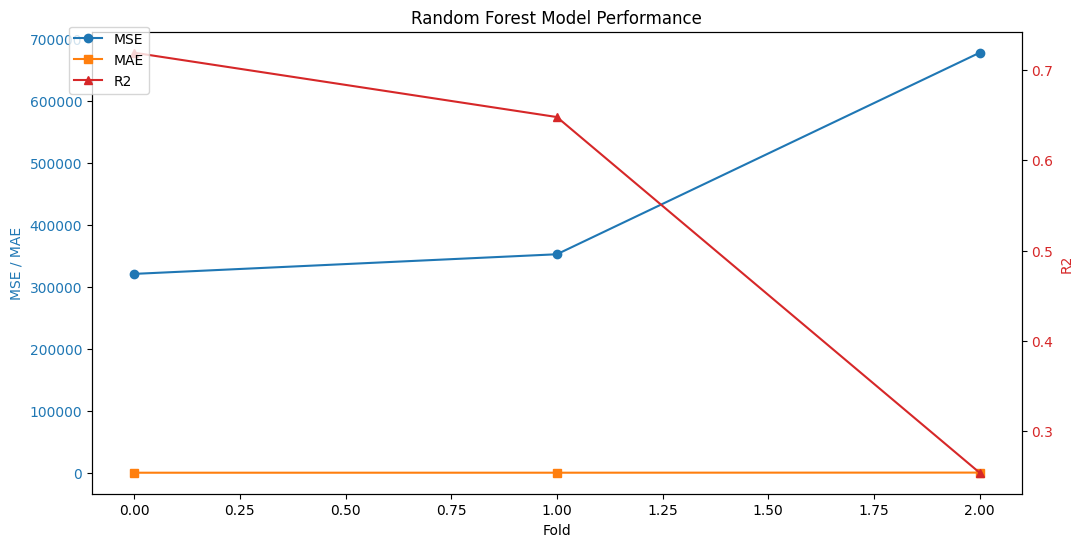

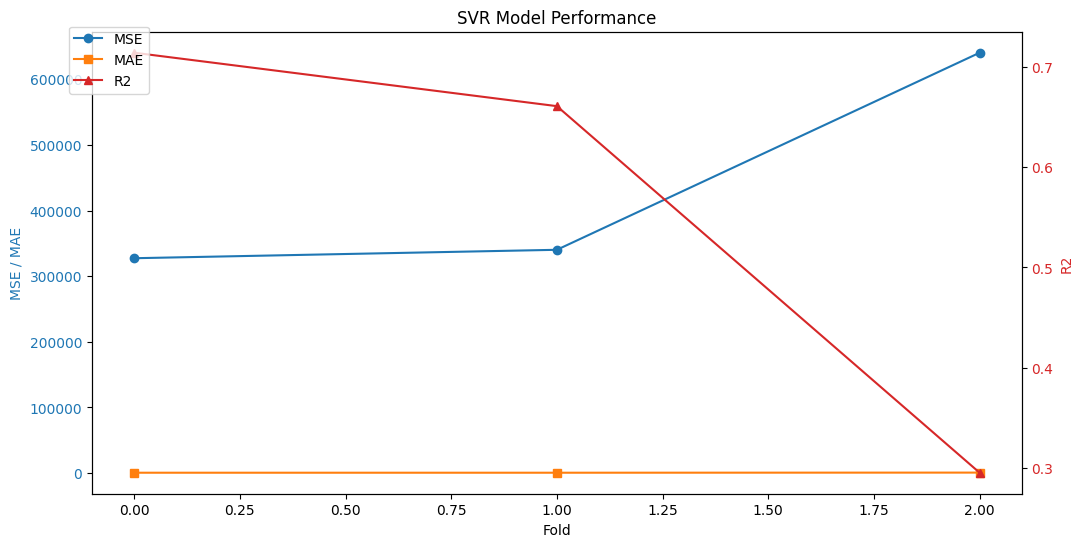

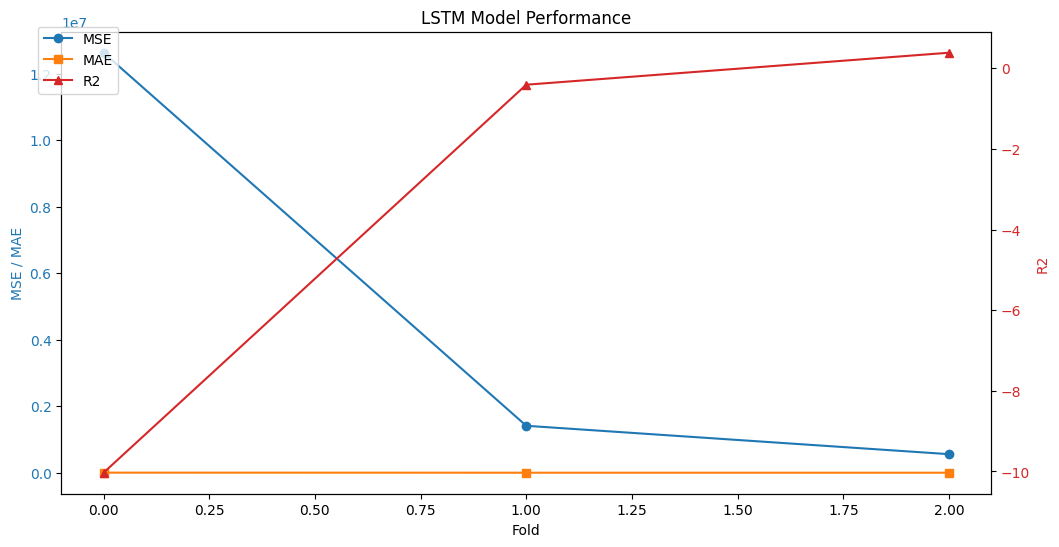

In [51]:
# 绘制每种模型的性能曲线
plot_results(rf_results, 'Random Forest')
plot_results(svr_results, 'SVR')
plot_results(lstm_results, 'LSTM')

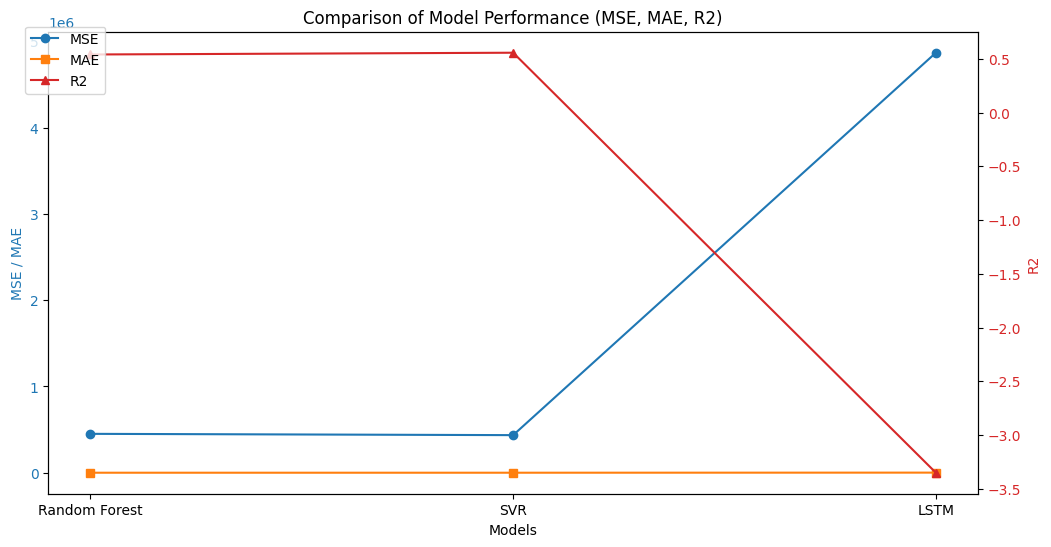

In [56]:
# 绘制三种模型的性能对比图
compare_models(rf_results, svr_results, lstm_results)